In [43]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from skimage.io import imread
from skimage.transform import resize
from tensorflow.python.framework.ops import reset_default_graph

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

# Kaggle challenge

In this lab we will work on a data science challenge from `kaggle.com`.
Kaggle is a website to participate in real life challenges.
Most competitions on kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about kaggle [here](https://www.kaggle.com/about).

OBS: You will need a kaggle account for this exercise!

The challenge we will pursue is the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge.
This is an image recognition challenge where each image is supplemented with three feature vectors (a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram).

The first task in a kaggle competition is to download, understand and preprocess the data, which we will do in the first section.

Afterwards, we will look into the type of neural network best suited for handling this type of data (for images, usually convolutional neural networks does a pretty good job).

Lastly, we will train the model and put the outputs in a submission file that we can submit to kaggle.
Convolution neural networks are one of the most succesfull types of neural networks for image recognition and an integral part of reigniting the interest in neural networks.

## Download data

Go to the [data section](https://www.kaggle.com/c/leaf-classification/data) of the Leaf Classification competition on kaggle.

Next, download all of the available data (`sample_submission.csv`, `train.csv`, `test.csv`, `images`), accept the disclaimer if asked and unzip all folders into the `lab4` folder.
Such that

```
>ls $PATH\_TO\_FOLDER/tensorflow_tutorial/lab4
images  lab4_Kaggle.ipynb  README.md  sample_submission.csv  test.csv  train.csv
```

Below we will try to load the data into memory and print it.

In [2]:
image_paths = glob.glob("images/*")
print "Amount of images =", len(image_paths)

Amount of images = 1584


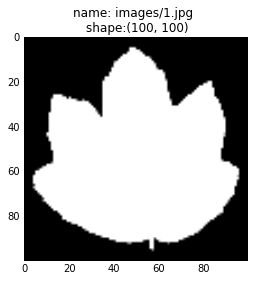

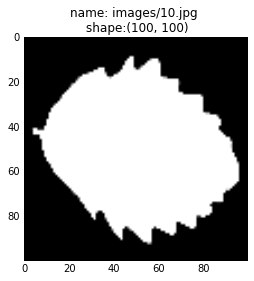

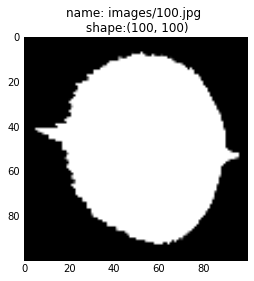

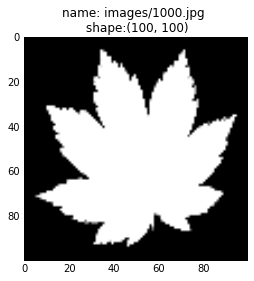

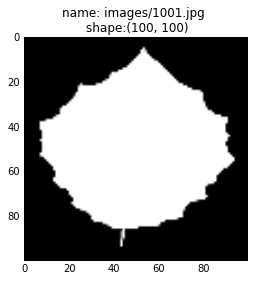

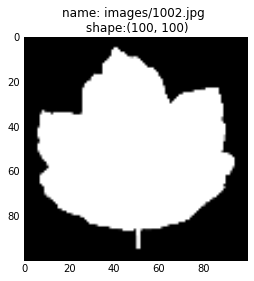

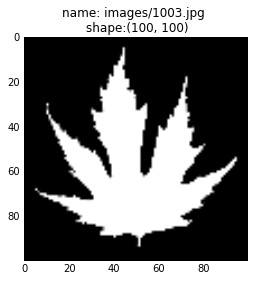

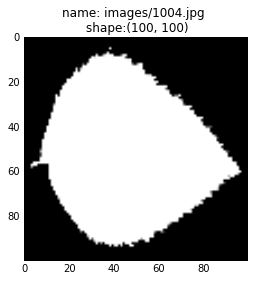

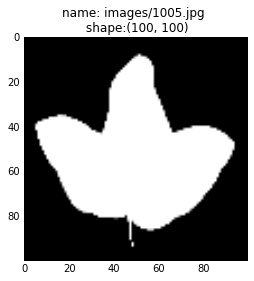

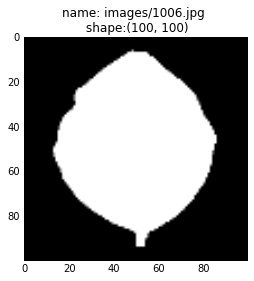

In [68]:
# now plot 10 images
# as we need all images to have the same dimensionality, we will resize and plot
# make the images as small as possible, until the difference between starts to get blurry
for i in range(10):
    image = imread(image_paths[i], as_grey=True)
    #image = resize(image, output_shape=(100, 100))
    plt.imshow(image, cmap='gray')
    plt.title("name: %s \n shape:%s" % (image_paths[i], image.shape))
    plt.show()

In [28]:
# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
# Notice how we "only" have 990 (989+0 elem) images for training, the rest is for testing
train.tail()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
985,1575,Magnolia_Salicifolia,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
986,1578,Acer_Pictum,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
987,1581,Alnus_Maximowiczii,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
988,1582,Quercus_Rubra,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930
989,1584,Quercus_Afares,0.023438,0.019531,0.031250,0.015625,0.005859,0.019531,0.035156,0.0,...,0.000000,0.000000,0.002930,0.000000,0.012695,0.000000,0.000000,0.023438,0.025391,0.022461


In [29]:
# name all columns in train, should be 3 different columns with 64 values each
print train.columns[2::64]

Index([u'margin1', u'shape1', u'texture1'], dtype='object')


X.shape, (990, 192)
margin.shape, (990, 64)
shape.shape, (990, 64)
texture.shape, (990, 64)


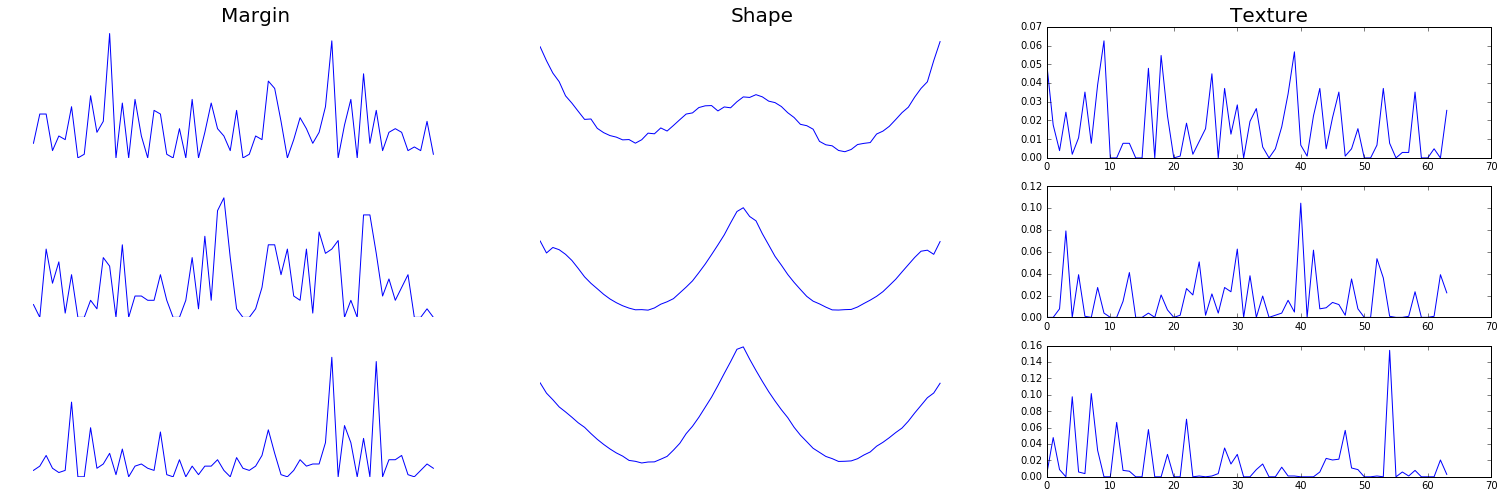

In [39]:
# try and extract and plot columns
X = train.as_matrix(columns=train.columns[2:])
print "X.shape,", X.shape
margin = X[:, :64]
shape = X[:, 64:128]
texture = X[:, 128:]
print "margin.shape,", margin.shape
print "shape.shape,", shape.shape
print "texture.shape,", texture.shape
# let us plot some of the features
plt.figure(figsize=(21,7))
for i in range(3):
    plt.subplot(3,3,1+i*3)
    plt.plot(margin[i])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(3,3,2+i*3)
    plt.plot(shape[i])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(3,3,3+i*3)
    plt.plot(texture[i])
    if i == 0:
        plt.title('Texture', fontsize=20)

plt.tight_layout()
plt.show()

# Exercise

1. Test various resizings of the image until you have found the smallest resizing of the image where you can still see differentiate between the images.

2. From the illustration of the Margin, Shape and Texture, what do you see? And how can it be used to classify?

3. Describe what network you would build and how you would represent the data points (image, margin, shape and texture).

# Building data loader

In [ ]:
def load_data_train(train_path, test_path, image_paths, image_size=(64, 64)):
    print "loading training data ..."
    # load train.csv
    train = pd.read_csv(train_path)
    # handle lack of order in image_paths and merge it with train
    path_dict = dict()
    for image_path in image_paths:
        num_path = int(os.path.basename(image_path[:-4]))
        path_dict[num_path] = image_path
    path_dict_train = dict()
    for index, row in train.iterrows():
        path_dict_train[row['id']] = path_dict[row['id']]
        path_dict[row['id']]
    image_frame = pd.DataFrame(path_dict_train.values(), columns=['image'])
    train_image =  pd.concat([image_frame, train], axis=1)
    # labels
    le = LabelEncoder().fit(train_image['species'])
    t_train = le.transform(train_image['species'])
    # make dataset
    X_train = dict()
    # merge image with 3x64 features
    for i, dat in enumerate(train_image.iterrows()):
        index, row = dat
        sample = dict()
        features = row.drop(['id', 'species', 'image'], axis=0).values
        sample['margin'] = features[:64]
        sample['shape'] = features[64:128]
        sample['texture'] = features[128:]
        sample['t'] = t_train[i]
        image = imread(row['image'], as_grey=True)
        image = resize(image, output_shape=image_size)
        image = np.expand_dims(image, axis=2)
        sample['image'] = image   
        X_train[row['id']] = sample
        if i % 100 == 0:
            print "\t", i
    print "training data loaded"
    return X_train

class make_batch():
    def __init__(self, X_train, X_test):
        self.X_train = X_train
        self.X_test = X_test
        self.idxs_train = X_train
        self.max_idx = max(idxs_train)

    def shuffle_train(self):
        np.random.shuffle(self.idxs_train)

    def train():
        for idx in idxs_train:
            # do the batch function from frostings ...
def make_batch_train(X_train, batch_size=64):
    indexes = X_train.keys()
    indexes
    for 

In [143]:
train_path = "train.csv"
test_path = "test.csv"
image_paths = glob.glob("images/*.jpg")
X_train, t_train = load_data_train(train_path, test_path, image_paths)

loading training data ...
	0
	100
	200
	300
	400
	500
	600
	700
	800
	900
training data loaded


In [144]:
X_train.keys()

[1,
 2,
 3,
 5,
 6,
 8,
 10,
 11,
 14,
 15,
 17,
 18,
 20,
 21,
 22,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 34,
 35,
 37,
 38,
 40,
 42,
 43,
 45,
 48,
 49,
 50,
 54,
 55,
 56,
 58,
 60,
 61,
 63,
 64,
 66,
 67,
 69,
 71,
 72,
 73,
 75,
 76,
 78,
 80,
 81,
 82,
 83,
 84,
 85,
 87,
 88,
 92,
 100,
 101,
 103,
 106,
 107,
 108,
 109,
 115,
 116,
 118,
 120,
 122,
 124,
 127,
 129,
 130,
 132,
 133,
 134,
 139,
 140,
 142,
 143,
 145,
 146,
 148,
 149,
 152,
 153,
 155,
 160,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 171,
 173,
 175,
 178,
 179,
 183,
 186,
 188,
 189,
 190,
 194,
 196,
 198,
 199,
 201,
 202,
 203,
 204,
 206,
 211,
 212,
 214,
 215,
 216,
 217,
 218,
 219,
 224,
 225,
 227,
 228,
 231,
 233,
 235,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 245,
 246,
 247,
 248,
 249,
 252,
 253,
 256,
 257,
 258,
 259,
 260,
 262,
 263,
 265,
 267,
 268,
 269,
 270,
 273,
 275,
 278,
 280,
 282,
 283,
 286,
 288,
 289,
 290,
 291,
 294,
 298,
 302,
 303,
 304,
 306,
 307,
 309,
 310,
 31

In [63]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(train['species'])
y_train = le.transform(train['species'])
y_train

0

In [ ]:
#LOAD the mnist data. To speed up training we'll only work on a subset of the data.
#Note that we reshape the data from (nsamples, num_features)= (nsamples, nchannels*rows*cols)  -> (nsamples, nchannels, rows, cols)
# in order to retain the spatial arrangements of the pixels
data = np.load('mnist.npz')
num_classes = 10
nchannels,rows,cols = 1,28,28
x_train = data['X_train'][:50000].astype('float32')
x_train = x_train.reshape((-1,nchannels,rows,cols))
targets_train = data['y_train'][:50000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
x_valid = x_valid.reshape((-1,nchannels,rows,cols))
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
x_test = x_test.reshape((-1,nchannels,rows,cols))
targets_test = data['y_test'][:500].astype('int32')

print "Information on dataset"
print "x_train", x_train.shape
print "targets_train", targets_train.shape
print "x_valid", x_valid.shape
print "targets_valid", targets_valid.shape
print "x_test", x_test.shape
print "targets_test", targets_test.shape

In [ ]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

### Documentation on contrib layers
Check out the [github page](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py) for information on contrib layers (not well documented in their api).

In [ ]:
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, batch_norm, max_pool2d, dropout
from tensorflow.python.ops.nn import relu, elu, relu6, sigmoid, tanh, softmax

In [ ]:
# define a simple feed forward neural network

# hyperameters of the model
num_classes = 10
channels = x_train.shape[1]
height = x_train.shape[2]
width = x_train.shape[3]
num_filters_conv1 = 16
kernel_size_conv1 = [5, 5] # [height, width]
stride_conv1 = [1, 1] # [stride_height, stride_width]
num_l1 = 100
# resetting the graph ...
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_pl = tf.placeholder(tf.float32, [None, channels, height, width])
l_reshape = tf.transpose(x_pl, [0, 2, 3, 1]) # TensorFlow uses NHWC instead of NCHW
is_training = tf.placeholder(tf.bool)

# Building the layers of the neural network
# we define the variable scope, so we more easily can recognise our variables later
l_conv1 = convolution2d(l_reshape, num_filters_conv1, kernel_size_conv1, stride_conv1, scope="l_conv1")
l_flatten = flatten(l_conv1, scope="flatten")
l1 = fully_connected(l_flatten, num_l1, activation_fn=relu, scope="l1")
l1 = dropout(l1, is_training=is_training, scope="dropout")
y = fully_connected(l1, num_classes, activation_fn=softmax, scope="y")

In [ ]:
# y_ is a placeholder variable taking on the value of the target batch.
y_ = tf.placeholder(tf.float32, [None, num_classes])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_ * tf.log(y+1e-8), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

# defining our optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# applying the gradients
train_op = optimizer.minimize(cross_entropy)

In [ ]:
#Test the forward pass
x = np.random.normal(0,1, (45, 1,28,28)).astype('float32') #dummy data

sess = tf.Session()
sess.run(tf.initialize_all_variables())
res = sess.run(fetches=[y], feed_dict={x_pl: x, is_training: False})
print "y", res[0].shape

In [ ]:
#Training Loop
from confusionmatrix import ConfusionMatrix
batch_size = 100
num_epochs = 10
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = 0
        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            target_batch = targets_train[idx]
            feed_dict_train = {x_pl: x_batch, y_: onehot(target_batch, num_classes), is_training: True}
            fetches_train = [train_op, cross_entropy]
            res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
            batch_loss = res[1] #this will do the complete backprob pass
            cur_loss += batch_loss
        loss += [cur_loss/batch_size]

        confusion_valid = ConfusionMatrix(num_classes)
        confusion_train = ConfusionMatrix(num_classes)

        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            targets_batch = targets_train[idx]
            # what to feed our accuracy op
            feed_dict_eval_train = {x_pl: x_batch, is_training: False}
            # deciding which parts to fetch
            fetches_eval_train = [y]
            # running the validation
            res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
            # collecting and storing predictions
            net_out = res[0] 
            preds = np.argmax(net_out, axis=-1) 
            confusion_train.batch_add(targets_batch, preds)

        confusion_valid = ConfusionMatrix(num_classes)
        for i in range(num_batches_valid):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_valid[idx]
            targets_batch = targets_valid[idx]
            # what to feed our accuracy op
            feed_dict_eval_train = {x_pl: x_batch, is_training: False}
            # deciding which parts to fetch
            fetches_eval_train = [y]
            # running the validation
            res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
            # collecting and storing predictions
            net_out = res[0]
            preds = np.argmax(net_out, axis=-1) 

            confusion_valid.batch_add(targets_batch, preds)

        train_acc_cur = confusion_train.accuracy()
        valid_acc_cur = confusion_valid.accuracy()

        train_acc += [train_acc_cur]
        valid_acc += [valid_acc_cur]
        print "Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
        % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur)
except KeyboardInterrupt:
    pass
    

#get test set score
confusion_test = ConfusionMatrix(num_classes)
# what to feed our accuracy op
feed_dict_eval_train = {x_pl: x_test, is_training: False}
# deciding which parts to fetch
fetches_eval_train = [y]
# running the validation
res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
# collecting and storing predictions
net_out = res[0] 
preds = np.argmax(net_out, axis=-1) 
confusion_test.batch_add(targets_test, preds)
print "\nTest set Acc:  %f" %(confusion_test.accuracy())


epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments 1

 1) Note the performance of the standard feedforward neural network. Add a 2D convolution layer before the dense hidden layer and confirm that it increases the generalization performance of the network (try num_filters=16 and filter_size=5 as a starting point). 
 
 2) Can the performance be increases even further by stacking more convolution layers ?
 
 3) Maxpooling is a technique for decreasing the spatial resolution of an image while retaining the important features. Effectively this gives a local translational invariance and reduces the computation by a factor of four. In the classification algorithm which is usually desirable. Try to either: 
 
     a) add a maxpool layer(add arguement pool_size=2)  after the convolution layer or
     b) set add stride=2 to the arguments of the convolution layer. 
  Verify that this decreases spatial dimension of the image. (print l_conv.output_shape or print   l_maxpool.output_shape). Does this increase the performance of the network (you may need to stack multiple layers or increase the number of filters to increase performance) ?
  


# Visualization of filters
Convolution filters can be interpreted as spatial feature detectors picking up different image features such as edges, corners etc. Below we provide code for visualization of the filters. The best results are obtained with fairly large filters of size 9 and either 16 or 36 filters. 

In [ ]:
# to start with we print the names of the weights in our graph
# to see what operations we are allowed to perform on the variables in our graph, try:
#print(dir(tf.all_variables()[0]))
# you will notice it has "name" and "value", which we will build a dictionary from
names_and_vars = {var.name: sess.run(var.value()) for var in tf.all_variables()}
print(names_and_vars.keys())
# getting the name was easy, just use .name on the variable object
# getting the value in a numpy array format is slightly more tricky
# we need to first get a variable object, then turn it into a tensor with .value()
# and the evaluate the tensor with sess.run(...)

In [ ]:
### If you get a key error, then you need to define l_conv1 in your model!
np_W = names_and_vars[u'l_conv1/weights:0'] # get the filter values from the first conv layer
print np_W.shape, "i.e. the shape is filter_size, filter_size, num_channels, num_filters"
filter_size, _, num_channels, num_filters = np_W.shape
n = int(num_filters**0.5)

# reshaping the last dimension to be n by n
np_W_res = np_W.reshape(filter_size, filter_size, num_channels, n, n)
fig, ax = plt.subplots(n,n)
print "learned filter values"
for i in range(n):
    for j in range(n):
        ax[i,j].imshow(np_W_res[:,:,0,i,j], cmap='gray',interpolation='none')
        ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())


idx = 1
plt.figure()
plt.imshow(x_train[idx,0],cmap='gray',interpolation='none')
plt.title('Inut Image')
plt.show()

#visalize the filters convolved with an input image
from scipy.signal import convolve2d
np_W_res = np_W.reshape(filter_size, filter_size, num_channels, n, n)
fig, ax = plt.subplots(n,n,figsize=(9,9))
print "Response from input image convolved with the filters"
for i in range(n):
    for j in range(n):
        ax[i,j].imshow(convolve2d(x_train[1,0],np_W_res[:,:,0,i,j],mode='same'), cmap='gray',interpolation='none')
        ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())



# Assignment 2

The visualized filters will likely look most like noise due to the small amount of training data.

 1) Try to use 10000 traning examples instead and visualise the filters again
 
 2) Dropout is a very usefull technique for preventing overfitting. Try to add a DropoutLayer after the convolution layer and hidden layer. This should increase both performance and the "visual appeal" of the filters
 
 3) Batch normalization is a recent innovation for improving generalization performance. Try to insert batch normalization layers into the network to improve performance. 
 
 


# More Fun with convolutional networks
### Get the data

In [ ]:
!wget -N https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz

In the data the each mnist digit (20x20 pixels) has been placed randomly in a 60x60 canvas. To make the task harder each canvas has then been cluttered with small pieces of digits. In this task it is helpfull for a network if it can focus only on the digit and ignore the rest.

The ``TransformerLayer`` lets us do this. The transformer layer learns an affine transformation which lets the network zoom, rotate and skew. If you are interested you should read the paper, but the main idea is that you can let a small convolutional network determine the the parameters of the affine transformation. You then apply the affine transformation to the input data. Usually this also involves downsampling which forces the model to zoom in on the relevant parts of the data. After the affine transformation we can use a larger conv net to do the classification. 
This is possible because you can backprop through a an affine transformation if you use bilinear interpolation.

In [ ]:
import os
import matplotlib
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, max_pool2d
pool = max_pool2d
conv = convolution2d
dense = fully_connected
from tensorflow.python.ops.nn import relu, softmax
from tensorflow.python.framework.ops import reset_default_graph

from spatial_transformer import transformer

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

NUM_EPOCHS = 500
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"

In [ ]:
def load_data():
    data = np.load(mnist_cluttered)
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    print "Train samples:", X_train.shape
    print "Validation samples:", X_valid.shape
    print "Test samples:", X_test.shape

    return dict(
        X_train=np.asarray(X_train, dtype='float32'),
        y_train=y_train.astype('int32'),
        X_valid=np.asarray(X_valid, dtype='float32'),
        y_valid=y_valid.astype('int32'),
        X_test=np.asarray(X_test, dtype='float32'),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data()

idx = 0
canvas = np.zeros((DIM*10, 10*DIM))
for i in range(10):
    for j in range(10):
        canvas[i*DIM:(i+1)*DIM, j*DIM:(j+1)*DIM] = data['X_train'][idx].reshape((DIM, DIM))
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('Cluttered handwritten digits')
plt.axis('off')

plt.show()

## Building the model

We use a model where the localization network is a two layer convolution network which operates directly on the image input. The output from the localization network is a 6 dimensional vector specifying the parameters in the affine transformation.

We set up the transformer layer to initially do the identity transform, similarly to [1]. If the output from the localization networks is [t1, t2, t3, t4, t5, t6] then t1 and t5 determines zoom, t2 and t4 determines skewness, and t3 and t6 move the center position. By setting the initial values of the bias vector to 

```
|1, 0, 0|
|0, 1, 0|
```
and the final W of the localization network to all zeros we ensure that in the beginning of training the network works as a pooling layer. 

The output of the localization layer feeds into the transformer layer which applies the transformation to the image input. In our setup the transformer layer downsamples the input by a factor 3.

Finally a 2 layer convolution layer and 2 fully connected layers calculates the output probabilities.


### The model
```
Input -> localization_network -> TransformerLayer -> output_network -> predictions
   |                                |
   >--------------------------------^
```




In [ ]:
reset_default_graph()
def build_model(x_pl, input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    # Setting up placeholder, this is where your data enters the graph!
    l_reshape = tf.transpose(x_pl, [0, 2, 3, 1]) # TensorFlow uses NHWC instead of NCHW

    # make distributed representation of input image for localization network
    loc_l1 = pool(l_reshape, kernel_size=[2, 2], scope="loc_l1")
    loc_l2 = conv(loc_l1, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="loc_l2")
    loc_l3 = pool(loc_l2, kernel_size=[2, 2], scope="loc_l3")
    loc_l4 = conv(loc_l3, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="loc_l4")
    loc_l4_flatten = flatten(loc_l4, scope="loc_l4_flatten")
    loc_l5 = dense(loc_l4_flatten, num_outputs=50, activation_fn=relu, scope="loc_l5")
    # set up weights for transformation (notice we always need 6 output neurons)
    W_loc_out = tf.get_variable("W_loc_out", [50, 6], initializer=tf.constant_initializer(0.0))
    initial = np.array([[1, 0, 0], [0, 1, 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    b_loc_out = tf.Variable(initial_value=initial, name='b_loc_out')
    loc_out = tf.matmul(loc_l5, W_loc_out) + b_loc_out

    # spatial transformer
    l_trans1 = transformer(l_reshape, loc_out, out_size=(DIM//3, DIM//3))
    l_trans1.set_shape([None, DIM//3, DIM//3, 1])
    l_trans1_valid = tf.transpose(l_trans1, [0, 2, 3, 1]) # Back into NCHW for validation

    print "Transformer network output shape: ", l_trans1.get_shape()

    # classification network
    class_l1 = conv(l_trans1, num_outputs=16, kernel_size=[3, 3], scope="class_l1")
    class_l2 = pool(class_l1, kernel_size=[2, 2], scope="class_l2")
    class_l3 = conv(class_l2, num_outputs=16, kernel_size=[3, 3], scope="class_l3")
    class_l4 = pool(class_l3, kernel_size=[2, 2], scope="class_l4")
    class_l4_flatten = flatten(class_l4, scope="class_l4_flatten")
    class_l5 = dense(class_l4_flatten, num_outputs=256, activation_fn=relu, scope="class_l5")
    l_out = dense(class_l5, num_outputs=output_dim, activation_fn=softmax, scope="l_out")

    return l_out, l_trans1_valid

x_pl = tf.placeholder(tf.float32, [None, 1, DIM, DIM])
model, l_transform = build_model(x_pl, DIM, DIM, NUM_CLASSES)
#model_params = lasagne.layers.get_all_params(model, trainable=True)

In [ ]:
# y_ is a placeholder variable taking on the value of the target batch.
y_pl = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES])
lr_pl = tf.placeholder(tf.float32, shape=[])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_pl * tf.log(model+1e-8), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

# defining our optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr_pl)

# applying the gradients
train_op = optimizer.minimize(cross_entropy)

In [ ]:
#Test the forward pass
x = np.random.normal(0,1, (45, 1,60,60)).astype('float32') #dummy data

sess = tf.Session()
sess.run(tf.initialize_all_variables())
res = sess.run(fetches=[model], feed_dict={x_pl: x})
print "y", res[0].shape

### Training the model
Unfortunately NVIDIA has yet to squeeze a TitanX into a labtop and training convnets on CPU is painfully slow. After 10 epochs you should see that model starts to zoom in on the digits. 

In [ ]:
def train_epoch(X, y, learning_rate):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        if i % 10 == 0:
            print i,
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch_tr = X[idx]
        y_batch_tr = y[idx]
        fetches_tr = [train_op, cross_entropy, model]
        feed_dict_tr = {x_pl: X_batch_tr, y_pl: onehot(y_batch_tr, NUM_CLASSES), lr_pl: learning_rate}
        res = sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr)
        cost_batch, output_train = tuple(res[1:3])
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch_tr == preds)
    print ""
    return np.mean(costs), correct / float(num_samples)


def eval_epoch(X, y):
    fetches_val = [model, l_transform]
    feed_dict_val = {x_pl: X}
    res = sess.run(fetches=fetches_val, feed_dict=feed_dict_val)
    output_eval, transform_eval = tuple(res)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc, transform_eval

In [ ]:
valid_accs, train_accs, test_accs = [], [], []
learning_rate=0.0001
try:
    for n in range(NUM_EPOCHS):
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'], learning_rate)
        valid_acc, valid_trainsform = eval_epoch(data['X_valid'], data['y_valid'])
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]

        # learning rate annealing
        if (n+1) % 10 == 0:
            learning_rate = learning_rate * 0.7
            print "New LR:", learning_rate

        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}, test acc {4}".format(
                n, train_cost, train_acc, valid_acc, test_acc)
except KeyboardInterrupt:
    pass

### Plot errors and zoom

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(7,14))
for i in range(3):
    plt.subplot(321+i*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(322+i*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3).T, cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
    
    
plt.tight_layout()
plt.show()

# A few pointers for image classification
If you want do image classification using a pretrained model is often a good choice, especially if you have limited amounts of labeled data. 

An often used pretrained network is the VGG16 and VGG19. Lasagne has pretrained models in the [modelzoo](https://github.com/Lasagne/Recipes/tree/master/modelzoo). Torch7 and Tensorflow have similar pretrained models that you can find with google. 

Currently the best performing image networks is [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf). Torch7 has an interesting blog post about Residual nets. http://torch.ch/blog/2016/02/04/resnets.html


